> Copyright 2023 The Johns Hopkins University Applied Physics Laboratory LLC 
>
> All rights reserved.  
>
> Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so.
>
> THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR 
PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE 
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, 
TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE 
OR OTHER DEALINGS IN THE SOFTWARE.

# MICrONS Co-registration and Visualization

This notebook uses the `dandi`-hosted [MICrONS functional data](https://dandiarchive.org/dandiset/000402/draft) and `bossdb`-hosted [MICrONS structural data](https://bossdb.org/microns/minnie) to examine and visualize co-registered cells.

More specifically, we update the PlaneSegmentation tables from the MICrONS DandiSet with the automated coregistration IDs in the `apl_functional_coreg_forward_v5` CAVE table. This notebook demonstrates updating these IDs for a random session and scan, plotting two functional traces for connected neurons, and visualizing those two neurons in Neuroglancer. To analyze a specific session and scan, switch out the call to `random()` with the session and scan numbers of interest.

This notebook requires the file 'ScanUnit.pkl' to properly execute. This file contains a dataframe mapping the mask IDs (which are session/scan/field specific) to Unit IDs (which are session/sca specific.)

In [1]:
import urllib.parse
import json

from dandi.dandiapi import DandiAPIClient
from caveclient import CAVEclient

from fsspec.implementations.cached import CachingFileSystem
from fsspec import filesystem
from h5py import File
from pynwb import NWBHDF5IO
from pynwb.file import NWBFile
from pynwb.ophys import PlaneSegmentation


from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(24601)

### Open the CAVE table with the structural / functional coregistration metadata

The table below lists metadata for each neuron nucleus id which has been coregistered with a functional unit id. The `target_id` field is unique to a specific neuron. The `session`, `scan_idx`, and `unit_id` fields can be used to match a nucleus id to a functional mask ID.

In [3]:
cave = CAVEclient("minnie65_phase3_v1")
coreg = cave.materialize.query_table("apl_functional_coreg_forward_v5")

# We filter session 5 scan 7 due to lack of unit IDs for this scan
# Comment out the line below if you want to include this particular session/scan.
coreg = coreg[(coreg['session']!=5) & (coreg['scan_idx'] != 7)]

coreg.head()

,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,67007,2023-04-06 15:05:50.491194+00:00,t,255686,9,6,1913,2,8.941486,4.206369,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
1,65810,2023-04-06 15:05:49.502144+00:00,t,255686,9,4,7548,6,9.380808,-5.165012,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
3,46412,2023-04-06 15:04:43.197444+00:00,t,255686,7,5,1946,2,4.071072,3.306988,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
5,51603,2023-04-06 15:05:13.151548+00:00,t,524777,8,5,7536,6,5.339488,8.230698,524777,2020-09-28 22:45:05.521513+00:00,t,316.821012,105637160857796192,864691135355759567,"[297040, 162864, 20055]","[nan, nan, nan]","[nan, nan, nan]"
6,5449,2023-04-06 15:02:31.468506+00:00,t,524777,4,9,5814,6,5.245454,5.897833,524777,2020-09-28 22:45:05.521513+00:00,t,316.821012,105637160857796192,864691135355759567,"[297040, 162864, 20055]","[nan, nan, nan]","[nan, nan, nan]"


### Open the metadata table for the functional recording

This table has been pulled from a MICrONS [DataJoint](https://datajoint.com/) database for convenience. The extra step is necessary because the dandiset identifies neurons by their mask IDs, not their unit IDs. Unit IDs are unique across a Dandi NWB file while mask IDs are unique within a field.

In [4]:
scan_units = pd.read_pickle("./ScanUnit.pkl")
scan_units.head()

,session,scan_idx,unit_id,field,mask_id,um_x,um_y,um_z,px_x,px_y,ms_delay
0,4,7,1,1,1,-778,-771,80,7,5,0
1,4,7,2,1,2,-741,-766,80,22,7,0
2,4,7,3,1,3,-691,-776,80,41,3,0
3,4,7,4,1,4,-691,-766,80,42,8,0
4,4,7,5,1,5,-702,-767,80,37,7,0


### Open the dandiset of interest

The Microns two-photon calcium scans are found in dandiset 000402. All sessions and scans can be browsed at https://dandiarchive.org/dandiset/000402/0.230307.2132/files?location=. We will choose an entry at random from the coregistration table and open the NWB file which holds its functional data.

In [5]:
coreg_row = coreg.sample(1).iloc[0] # randomly select a row from the coregisration table

session_no, scan_no, unit_id = coreg_row["session"], coreg_row["scan_idx"], coreg_row["unit_id"] 

# access scan unit row associated with the coregistration one
scan_unit_row = scan_units[(scan_units['session']==session_no)&(scan_units['scan_idx']==scan_no)&(scan_units['unit_id']==unit_id)]

dandiset_id = "000402"

display((session_no, scan_no, unit_id))

(7, 4, 9291)

Since each file is tens of GB large, use the NWB streaming capability to open the file without reading all of it into memory at once, as explained at https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html.

In [6]:
# Get the location of the file on DANDI
def get_NWBFile(session_no, scan_no):
    file_path = f"sub-17797/sub-17797_ses-{session_no}-scan-{scan_no}_behavior+image+ophys.nwb"
    with DandiAPIClient() as client:
        asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

    # First, create a virtual filesystem based on the http protocol
    fs = filesystem("http")

    # Create a cache to save downloaded data to disk (optional)
    fs = CachingFileSystem(
        fs=fs,
        cache_storage="nwb-cache",  # Local folder for the cache
    )

    # Next, open the file with NWBHDF5IO
    file_system = fs.open(s3_url, "rb")
    file = File(file_system, mode="r")
    io = NWBHDF5IO(file=file, load_namespaces=True)

    microns_data = io.read()
    return microns_data

microns_data = get_NWBFile(session_no, scan_no)

/Users/xenesd1/Projects/aplbrain/neurodatarehack2023/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/xenesd1/Projects/aplbrain/neurodatarehack2023/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/xenesd1/Projects/aplbrain/neurodatarehack2023/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


### Update the NWB File

The `NWBFile` object contains all the metadata associated with the dandiset. The attribute `processing -> ophys -> data_interfaces -> ImageSegmentation -> plane_segmentations` contains the structural ids associated with the image masks. The first step this notebook will take is to update each `PlaneSegmentation` object using the new structural ids which were published in 2023. These are found in the CAVE table `apl_functional_coreg_forward_v5`, column `target_id`. While we're in there, also add the unit IDs and other metadata from the CAVE table as columns.


In [7]:
# The following cell depends on these functions
def create_new_plane_segmentation(old, df, descriptions):
    ps = PlaneSegmentation(
        name=old.name, 
        description=old.description, 
        imaging_plane=old.imaging_plane,
        id=df.index.tolist()
    )
    
    for col in df.columns:
        if col in old.colnames:
            old_col = find_column_by_name(old, col)
            ps.add_column(name=old_col.name, description=old_col.description, data=df[col].tolist())
        else:
            ps.add_column(name=col, description=descriptions[col], data=df[col].tolist())
    return ps
        

def find_column_by_name(table,col_name):
    for c in table.columns:
        if c.name == col_name:
            return c

In [8]:
# Update the PlaneSegmentation objects in the NWB file
def update_microns_nwb_file(
    nwb: NWBFile,
    coreg,
    scan_units,
):
        
    session, scan_idx = int(nwb.session_id.split('-')[0]), int(nwb.session_id.split('-')[2])
    if session == 5 and scan_idx == 7:
        print("Error: This file does not contain a unit_id column")
        return 
    scan_units_modified = scan_units[(scan_units['session']==session) & (scan_units['scan_idx']==scan_idx)]
    
    image_segmentation = nwb.processing["ophys"].data_interfaces["ImageSegmentation"]
    
    all_ps = list(image_segmentation.plane_segmentations)
    for ps_name in tqdm(all_ps):
        
        ps = image_segmentation.plane_segmentations.pop(ps_name)
        field = int(ps_name[-1])
        field_scan_units = scan_units_modified[scan_units_modified['field'] == field]
        ps_df = ps[:]
        ps_df['mask_id'] = ps_df.index
        ps_df_with_units = ps_df.merge(field_scan_units, on='mask_id', how='left').drop(columns=[
            'mask_id', 'session', 'scan_idx'
            # 'mask_id', 'session', 'scan_idx', 'field'
        ])
        
        coreg_units = coreg[
            (coreg['session']==session) & 
            (coreg['scan_idx']==scan_idx) & 
            (coreg['field'] == field)
        ][['target_id', 'unit_id']]
        
        if len(coreg_units):
            ps_df_with_units = ps_df_with_units.merge(coreg_units, on='unit_id').rename(
                columns={
                    'target_id': 'auto_match_cave_nuclei_id', 
                    'cave_ids': 'manual_match_cave_nuclei_id'
                }
            )
        
        description = {x: "Placeholder" for x in ps_df_with_units.columns}
        new_ps = create_new_plane_segmentation(ps, ps_df_with_units, description)
        image_segmentation.plane_segmentations.add(new_ps)
        
    return nwb

In [9]:
# If this fails with "This file does not contain a unit_id column", then session 5 scan 7 was chosen.
# This file does not contain unit_ids, so a new random neuron must be chosen.
# Rerun the cells in Open the Dandiset of Interest to choose a new random neuron, then try this cell again.
microns_data = update_microns_nwb_file(microns_data, coreg, scan_units)

100%|██████████| 8/8 [00:23<00:00,  2.94s/it]


### Visualization

The functional data contains multiple types of data for a single mask ID. Plot the image of the mask and its fluorescence trace together.

In [10]:
# Return the mask image, fluorescence trace values, and timestamps for a given unit id
def get_time_series_data(unit_id):
    mask_id = 0
    for plane_seg in range(1, 9):
        image_seg = microns_data.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations[f"PlaneSegmentation{plane_seg}"]
        try:
            mask_id = image_seg.get("unit_id").data.index(unit_id)
        except:
            continue
        else:
            break

    if mask_id == 0:
        return Exception(f"Unit Id {unit_id} not found")

    # Get fluorescence of the table number
    fluor = microns_data.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series[f"RoiResponseSeries{plane_seg}"]

    # Pull the data we are interested in
    mask_image = image_seg.image_mask[mask_id]
    fluor_data = fluor.data[:, mask_id]
    timestamps = fluor.timestamps[:]

    return mask_image, fluor_data, timestamps

Text(0, 0.5, 'response magnitude')

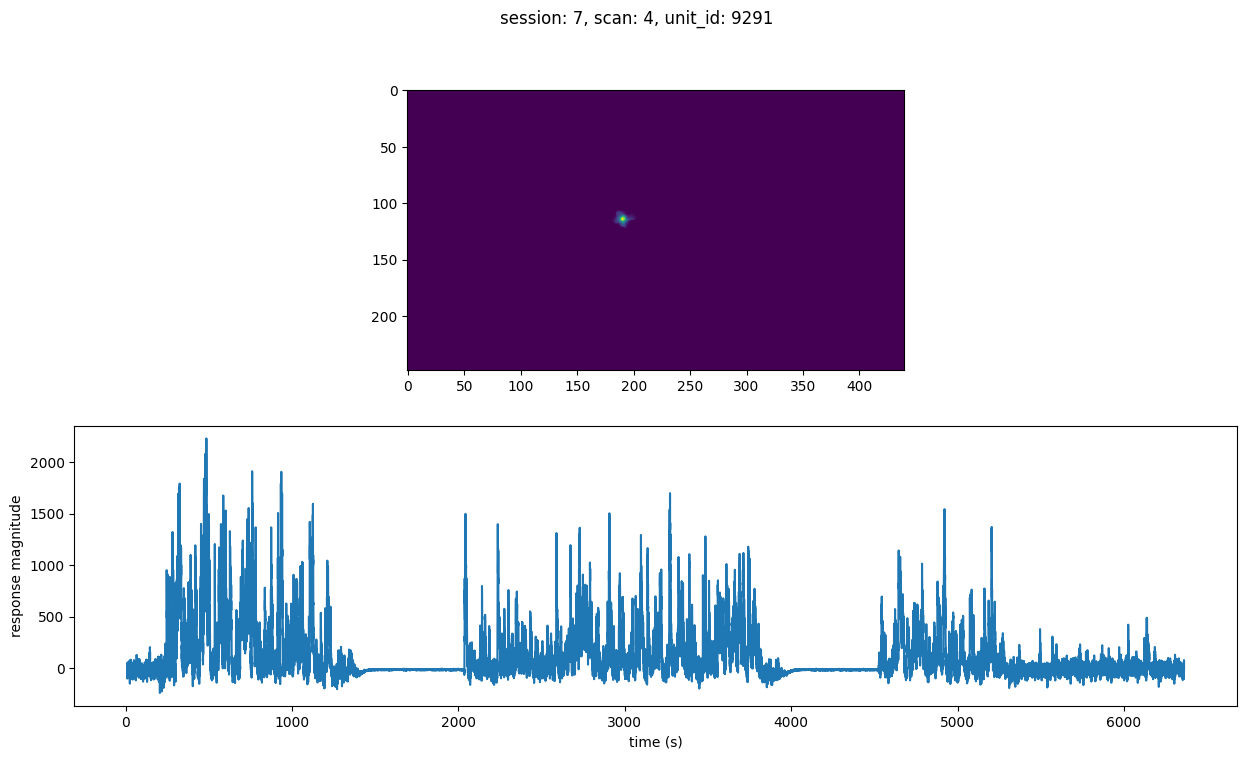

In [11]:
# Plot the segmentation and fluorescence trace for the unit id
mask_image, fluor, timestamps = get_time_series_data(unit_id)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle(f'session: {session_no}, scan: {scan_no}, unit_id: {unit_id}')
ax1.imshow(mask_image)
ax2.plot(timestamps, fluor)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("response magnitude")

## Neuroglancer Visualization 
Generate JSON states associated with the functional and structural information for a unit. Unit info is formatted in the tuple `(session_id, scan_id, field_id, unit_field_id)`.

In [12]:
from ng_utils import generate_functional_ng_state, generate_structural_ng_state, save_json

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


In [13]:
# The field ID is a new identifier not mentioned yet in this notebook. It is important for pulling the correct Neuroglancer layers.
# It was added as a column when we modified the PlaneSegmentation objects. Index into this column to grab the correct field ID.
def get_field_id(unit_id):
    mask_id = 0
    field_id = 0
    for plane_seg in range(1, 9):
        image_seg = microns_data.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations[f"PlaneSegmentation{plane_seg}"]
        try:
            mask_id = image_seg.get("unit_id").data.index(unit_id)
        except:
            continue
        else:
            field_id = image_seg.get("field").data[mask_id]
            break

    if mask_id == 0:
        return Exception(f"Unit Id {unit_id} not found")

    return field_id

In [14]:
# Generate Neuroglancer JSON states
# States will be saved to a file that can be copied into Neuroglancer's state editor

unit_info = (session_no, scan_no, get_field_id(unit_id), unit_id)

"""
Functional Test
"""
funct_ng_state, target_id = generate_functional_ng_state(unit_info)
save_json(f'functional_state_{"_".join([str(x) for x in unit_info])}.json', funct_ng_state)

"""
Structural Test
"""
struct_ng_state = generate_structural_ng_state(target_id)
save_json(f'structural_state_id_{"_".join([str(x) for x in unit_info])}.json', struct_ng_state)


In [15]:
# Alternatively, run this cell to open in browser
import webbrowser
funct_url = 'https://neuroglancer.neuvue.io/#!' + urllib.parse.quote(json.dumps(funct_ng_state))
struct_url = 'https://neuroglancer.neuvue.io/#!' + urllib.parse.quote(json.dumps(struct_ng_state))
webbrowser.open(funct_url)
webbrowser.open(struct_url)

True

### Connectivity-informed functional analysis

We can use the `pt_root_id` column in the coregistration table we pulled at the very beginning of the notebook to generate a list of neurons which synapse onto our neuron of interest, along with the quantity and pre/post designation of each synapse.

In [16]:
def generate_synapse_map(pt_root_id):
    return {
        'pre': cave.materialize.query_table("synapses_pni_2", 
            filter_equal_dict={"post_pt_root_id": str(pt_root_id)})['pre_pt_root_id'].value_counts().to_dict(),
        'post': cave.materialize.query_table("synapses_pni_2", 
            filter_equal_dict={"pre_pt_root_id": str(pt_root_id)})['post_pt_root_id'].value_counts().to_dict()
    }

pt_root_id = coreg_row["pt_root_id"]
synapse_map = generate_synapse_map(pt_root_id)

# Remove neuron cycles first if they exist.
del synapse_map['pre'][pt_root_id]
del synapse_map['post'][pt_root_id]

In [17]:
# Find a functionally characterized neuron in the list of post synaptic neurons
for post_pt_root_id in synapse_map['post']:
    coreg_row_2 = coreg.loc[coreg["pt_root_id"] == post_pt_root_id].head(1)
    if len(coreg_row_2) > 0: break
    
# Repeat the steps to pull the NWB file for the neuron
scan_unit_row_2 = scan_units.loc[coreg_row_2.index[0]]

session_no_2 = scan_unit_row_2["session"]
scan_no_2 = scan_unit_row_2["scan_idx"]
unit_id_2 = scan_unit_row_2["unit_id"]

microns_data_2 = get_NWBFile(session_no_2, scan_no_2)
microns_data_2 = update_microns_nwb_file(microns_data_2, coreg, scan_units)
#microns_data_2

/Users/xenesd1/Projects/aplbrain/neurodatarehack2023/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/xenesd1/Projects/aplbrain/neurodatarehack2023/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/xenesd1/Projects/aplbrain/neurodatarehack2023/venv/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


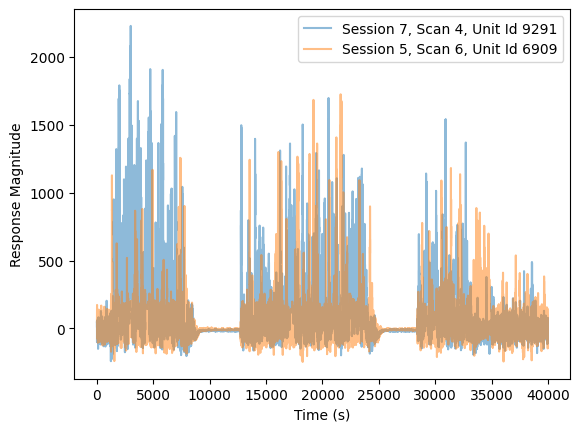

In [18]:
# Plot the two functional traces on top of each other

mask_image2, fluor2, timestamps2 = get_time_series_data(unit_id_2)

plt.plot(fluor, label=f"Session {session_no}, Scan {scan_no}, Unit Id {unit_id}", alpha=0.5)
plt.plot(fluor2, label=f"Session {session_no_2}, Scan {scan_no_2}, Unit Id {unit_id_2}", alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Response Magnitude")
plt.legend()